In [29]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tools2 import *


In [30]:
models = np.load('lab2_models.npz')['models']
tidigits = np.load('lab2_tidigits.npz')['tidigits']

In [31]:
models[0]['hmm']['startprob'].view()

array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [32]:
models[0]['hmm']['transmat'].view()

array([[ 0.94096471,  0.05903529,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.96007339,  0.03992661,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.97109309,  0.02890691,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.9751941 ,  0.0248059 ,
         0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.92895844,
         0.07104156,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.91749739,  0.08250261,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.96006789,  0.03993211,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0

In [33]:
examples = np.load('lab2_example.npz')['example']
example = examples.item()

True
222


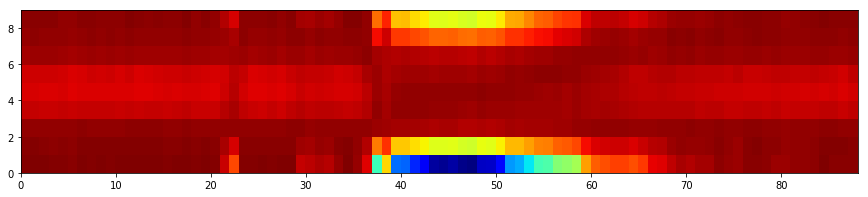

In [34]:
hmm_model = models[0]['hmm']
means = hmm_model['means']
covars = hmm_model['covars']
r = log_multivariate_normal_density_diag(example['mfcc'], means, covars)
print np.allclose(example['hmm_obsloglik'], r)
print np.count_nonzero(r - example['hmm_obsloglik'])
plt.figure(figsize=(15,3))
plt.pcolormesh(r.T, cmap='jet')

(88, 9)
True


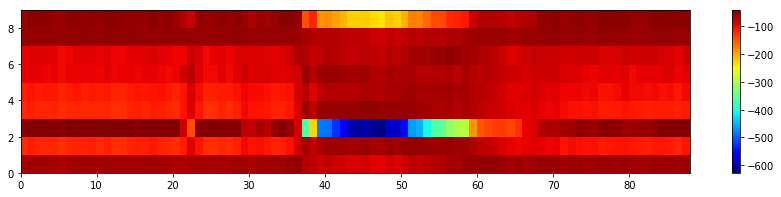

In [35]:
gmm_model = models[0]['gmm']
means = gmm_model['means']
covars = gmm_model['covars']
log_emlik = log_multivariate_normal_density_diag(example['mfcc'], means, covars)
print log_emlik.shape
print np.allclose(example['gmm_obsloglik'], log_emlik)
plt.figure(figsize=(15,3))
plt.pcolormesh(log_emlik.T, cmap='jet')
plt.colorbar()

In [36]:
def gmmloglik(log_emlik, weights):
    """Log Likelihood for a GMM model based on Multivariate Normal Distribution.

    Args:
        log_emlik: array like, shape (N, K).
            contains the log likelihoods for each of N observations and
            each of K distributions
        weights:   weight vector for the K components in the mixture

    Output:
        gmmloglik: scalar, log likelihood of data given the GMM model.
    """
    #return np.sum(np.log(np.dot(np.exp(log_emlik), weights)))
    l=log_emlik.shape[0]
    gmmloglik = 0
    for i in xrange(l):
        gmmloglik += logsumexp(np.log(weights) + log_emlik[i,:])
    return gmmloglik

In [37]:
weights = models[0]['gmm']['weights']
r = gmmloglik(log_emlik,  weights)

# GMM Maximum Likelihood

In [38]:
correct = 0
for tidigit in tidigits:
    digit = tidigit['digit']
    best_model = None
    best_score = float('-inf')
    for model_idx in xrange(len(models)):
        model = models[model_idx]
        gmm_model = model['gmm']
        means = gmm_model['means']
        covars = gmm_model['covars']
        weights = gmm_model['weights']
        
        log_emlik = log_multivariate_normal_density_diag(tidigit['mfcc'], means, covars)
        score = gmmloglik(log_emlik, weights)
        if best_score < score:
            best_score = score
            best_model = model
            
    if digit == best_model['digit']:
        correct += 1
            
accuracy = float(correct) / len(tidigits)
print accuracy

1.0


In [39]:
def forward(log_emlik, log_startprob, log_transmat):
    """Forward probabilities in log domain.

    Args:
        log_emlik: NxM array of emission log likelihoods, N frames, M states
        log_startprob: log probability to start in state i
        log_transmat: log transition probability from state i to j

    Output:
        forward_prob: NxM array of forward log probabilities for each of the M states in the model
    """
    N, M = log_emlik.shape
    forward_prob = np.zeros((N,M))
    forward_prob[0,:] = log_startprob + log_emlik[0]
    for n in xrange(1, N):
        for j in xrange(M):
            forward_prob[n,j] = logsumexp(forward_prob[n-1,:] + log_transmat[:,j]) + log_emlik[n,j]
    return forward_prob

In [40]:
model = models[0]
hmm_model = model['hmm']
means = hmm_model['means']
covars = hmm_model['covars']
log_emlik = log_multivariate_normal_density_diag(example['mfcc'], means, covars)
log_startprob = np.log(hmm_model['startprob'])
log_transmat = np.log(hmm_model['transmat'])
alpha = forward(log_emlik, log_startprob, log_transmat)
print np.allclose(alpha, example['hmm_logalpha'])

True


/Users/hwaxxer/.virtualenvs/lab/lib/python2.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  
/Users/hwaxxer/.virtualenvs/lab/lib/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


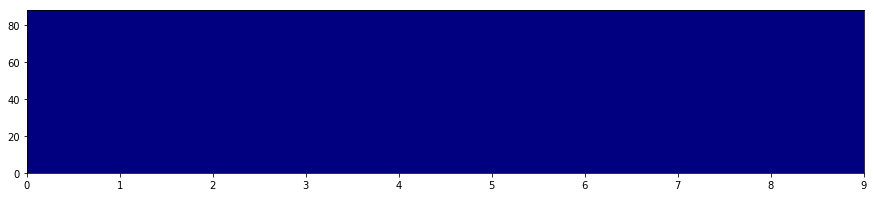

In [41]:
plt.figure(figsize=(15,3))
plt.pcolormesh(alpha, cmap='jet')

# HMM Maximum Likelihood

$\alpha_n(j)$ is the probability of observing the sequence up until timestep n, and being in state j at timestep n.

We marginalize over the possible states to obtain the total probability of the observation sequence up until timestep n given the parameters.

\begin{equation}
P(X|\theta) = \sum_j^M P(x_0, ..., x_n, z_n=s_j | \theta) = \sum_j^M \alpha_n(j)
\end{equation}

In [42]:
hmm_loglik = logsumexp(alpha[-1])
print hmm_loglik
print example['hmm_loglik']
print np.allclose(hmm_loglik, example['hmm_loglik'])

-4362.86832817
-4362.86832817
True


In [43]:
correct = 0
alphas = []
for tidigit in tidigits:
    digit = tidigit['digit']
    best_model = None
    best_score = float('-inf')
    for model_idx in xrange(len(models)):
        model = models[model_idx]
        hmm_model = model['hmm']
        means = hmm_model['means']
        covars = hmm_model['covars']
        
        log_emlik = log_multivariate_normal_density_diag(tidigit['mfcc'], means, covars)
        
        log_startprob = np.log(hmm_model['startprob'])
        log_transmat = np.log(hmm_model['transmat'])
        alpha = forward(log_emlik, log_startprob, log_transmat)
        alphas.append(alpha)
        score = logsumexp(alpha[-1])
        if best_score < score:
            best_score = score
            best_model = model
            
    if digit == best_model['digit']:
        correct += 1
            
accuracy = float(correct) / len(tidigits)
print accuracy

/Users/hwaxxer/.virtualenvs/lab/lib/python2.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app
/Users/hwaxxer/.virtualenvs/lab/lib/python2.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()


0.954545454545


(91, 9)
-52.16120975


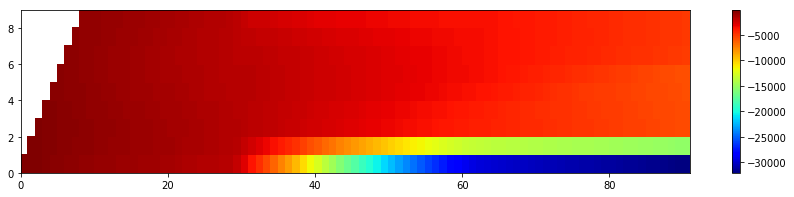

In [44]:
import matplotlib as mpl
print alphas[0].shape
plt.figure(figsize=(15,3))
# plt.imshow(alphas[0].T, cmap='jet')
print alphas[0].max()

plt.pcolormesh(np.ma.masked_invalid(np.atleast_2d(alphas[0])).T, cmap='jet')
plt.colorbar()

# HMM Maximum Likelihood (as Gaussians with equal weights)

In [45]:
correct = 0
for tidigit in tidigits:
    digit = tidigit['digit']
    best_model = None
    best_score = float('-inf')
    for model_idx in xrange(len(models)):
        model = models[model_idx]
        hmm_model = model['hmm']
        means = hmm_model['means']
        covars = hmm_model['covars']
        weights = np.ones(len(means)) / len(means)
        
        log_emlik = log_multivariate_normal_density_diag(tidigit['mfcc'], means, covars)
        score = gmmloglik(log_emlik, weights)
        if best_score < score:
            best_score = score
            best_model = model
            
    if digit == best_model['digit']:
        correct += 1
            
accuracy = float(correct) / len(tidigits)
print accuracy

1.0


In [46]:
def viterbi(log_emlik, log_startprob, log_transmat):
    """Viterbi path.

    Args:
        log_emlik: NxM array of emission log likelihoods, N frames, M states
        log_startprob: log probability to start in state i
        log_transmat: transition log probability from state i to j

    Output:
        viterbi_loglik: log likelihood of the best path
        viterbi_path: best path
    """
    N, M = log_emlik.shape
    viterbi_path = np.empty((N), dtype=np.int)
    viterbi_loglik = 0
    V = np.zeros((N,M))
    B = np.zeros((N,M))
    
    for j in xrange(M):
        V[0, j] = log_startprob[j] + log_emlik[0,j]
        
    for n in xrange(1,N):
        for j in xrange(M):
            V[n, j] = np.max(V[n-1,:] + log_transmat[:,j]) + log_emlik[n,j]
            B[n, j] = np.argmax(V[n-1,:] + log_transmat[:,j])
    
    viterbi_path[-1] = np.argmax(V[-1, :])
    viterbi_loglik = V[N-1, viterbi_path[-1]]
    
    for n in xrange(0,N-1):
        viterbi_path[n] += np.max(V[n-1,:])
    
    for n in reversed(xrange(N-1)):
        for j in xrange(M):
            viterbi_path[n] = B[n+1, viterbi_path[n+1]]
    return (viterbi_loglik, viterbi_path)

In [47]:
model = models[0]
hmm_model = model['hmm']
means = hmm_model['means']
covars = hmm_model['covars']
log_emlik = log_multivariate_normal_density_diag(example['mfcc'], means, covars)
log_startprob = np.log(hmm_model['startprob'])
log_transmat = np.log(hmm_model['transmat'])
hmm_vloglik = viterbi(log_emlik, log_startprob, log_transmat)
print np.allclose(hmm_vloglik[0], example['hmm_vloglik'][0])
print np.allclose(hmm_vloglik[1], example['hmm_vloglik'][1])

True
True


/Users/hwaxxer/.virtualenvs/lab/lib/python2.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  
/Users/hwaxxer/.virtualenvs/lab/lib/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


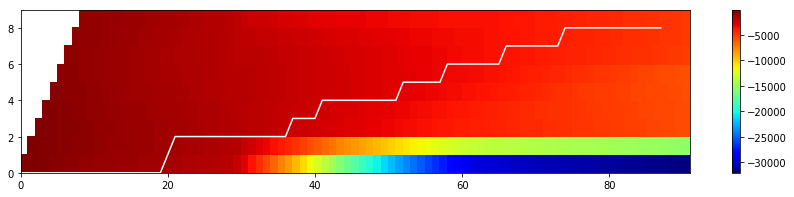

In [48]:
plt.figure(figsize=(15,3))
plt.pcolormesh(np.ma.masked_invalid(np.atleast_2d(alphas[0])).T, cmap='jet')
plt.plot(hmm_vloglik[-1], c='w')
plt.colorbar()

# HMM Viterbi Maximum Likelihood

In [49]:
correct = 0
for tidigit in tidigits:
    digit = tidigit['digit']
    best_model = None
    best_score = float('-inf')
    for model_idx in xrange(len(models)):
        model = models[model_idx]
        hmm_model = model['hmm']
        means = hmm_model['means']
        covars = hmm_model['covars']
        
        log_emlik = log_multivariate_normal_density_diag(tidigit['mfcc'], means, covars)
        
        log_startprob = np.log(hmm_model['startprob'])
        log_transmat = np.log(hmm_model['transmat'])
        score, path = viterbi(log_emlik, log_startprob, log_transmat)
        if best_score < score:
            best_score = score
            best_model = model
            
    if digit == best_model['digit']:
        correct += 1
            
accuracy = float(correct) / len(tidigits)
print accuracy

/Users/hwaxxer/.virtualenvs/lab/lib/python2.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  
/Users/hwaxxer/.virtualenvs/lab/lib/python2.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app


0.954545454545


In [50]:
def backward(log_emlik, log_startprob, log_transmat):
    """Backward probabilities in log domain.

    Args:
        log_emlik: NxM array of emission log likelihoods, N frames, M states
        log_startprob: log probability to start in state i
        log_transmat: transition log probability from state i to j

    Output:
        backward_prob: NxM array of backward log probabilities for each of the M states in the model
    """
    N, M = log_emlik.shape
    beta = np.empty((N,M))
    beta[-1,:] = 0
    for n in reversed(xrange(N-1)):
        for i in xrange(M):
            beta[n,i] = logsumexp(log_transmat[i,:] + log_emlik[n+1,:] + beta[n+1,:])
    return beta

In [51]:
model = models[0]
hmm_model = model['hmm']
means = hmm_model['means']
covars = hmm_model['covars']
log_emlik = log_multivariate_normal_density_diag(example['mfcc'], means, covars)
log_startprob = np.log(hmm_model['startprob'])
log_transmat = np.log(hmm_model['transmat'])
b = backward(log_emlik, log_startprob, log_transmat)

np.allclose(b, example['hmm_logbeta'])

/Users/hwaxxer/.virtualenvs/lab/lib/python2.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  
/Users/hwaxxer/.virtualenvs/lab/lib/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


True

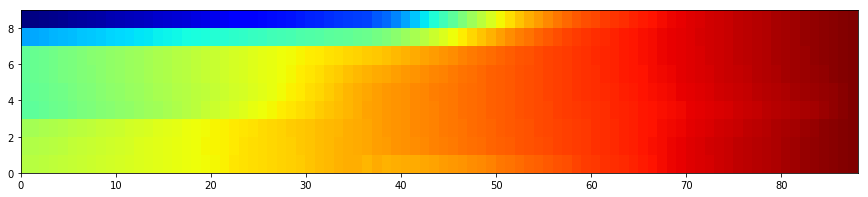

In [52]:
plt.figure(figsize=(15,3))
plt.pcolormesh(b.T, cmap='jet')